# Steuerungsentwurf für ein lineares und vollständig steuerbares System, dessen Ausgang kein flacher Ausgang ist

**(1. Übung Flachheitsbasierte Folgeregelung, Aufgabe 2)**

## Aufgabenstellung

Betrachtet wird ein System mit der Übertragungsfunktion

\begin{equation}
  G(s) = \frac{K (1 + T_n s)}{(1 + T_1s)(1 + T_2s)(1+T_3s)}
\end{equation}

welche den Zusammenhang zwischen dem Eingang $u$ (in Volt) und dem Ausgang $\eta$ (ebenfalls in Volt) im Bildbereich mit $K = 2.0$, $T_n = 1.5$s, $T_1 = 1.0$s, $T_2 = 2.0$s, $T_3 = 3.0$ beschreibt.

Eine Zustandsdarstellung für dieses System lautet wie folgt:

\begin{align*}
\dot x_1 & = x_2\\
\dot x_2 & = x_3\\
\dot x_3 & = -\frac{1}{T_1 T_2 T_3} x_1 - \frac{T_1 + T_2 + T_3}{T_1 T_2 T_3} x_2 - \frac{T_1 T_2 + T_1 T_3 + T_2 T_3}{T_1 T_2 T_3} x_3 + u \label{eq:u} \\
\eta     & = \frac{K}{T_1 T_2 T_3} x_1 + \frac{K T_n}{T_1 T_2 T_3} x_2.
\end{align*}
In dieser ist $y = x_1$ ein flacher Ausgang.

Nach Vorgabe von $\eta$ ist aus der Dgl.
\begin{equation*}
\eta = \frac{K}{T_1 T_2 T_3} y + \frac{K T_n}{T_1 T_2 T_3} \dot y
\end{equation*}
der Verlauf von $y$ zu bestimmen und daraus der Verlauf von $u$. Im stationären Zustand gilt:
\begin{equation*}
y_0 = \frac{T_1 T_2 T_3}{K}\eta_0
\end{equation*}

In diesem Notebook wird die analytische und numerische Lösung des Problems demonstriert.

Es handelt sich um eine "quick-and-dirty" Implementierung, um zügig zu Ergebnissen zu kommen.

---

Die aktuelle Fassung dieses Notebooks findet sich in folgendem Repositorium:

https://gitlab.hrz.tu-chemnitz.de/rst/public/teaching/flavert-nbviewer-content

**Sie können zur Entwicklung/ Verbesserung über Merge Requests beitragen!**

---

<p style="font-family:Courier New; font-size:10pt">
Copyright (c) 2023 Jan Winkler, TU Dresden, Germany
</p>

<p style="font-family:Courier New; font-size:10pt">
This program is free software: you can redistribute it and/or modify<br>
it under the terms of the GNU General Public License as published by<br>
the Free Software Foundation, either version 3 of the License, or<br>
(at your option) any later version.
</p>
    
<p style="font-family:Courier New; font-size:10pt">
This program is distributed in the hope that it will be useful,<br>
but WITHOUT ANY WARRANTY; without even the implied warranty of<br>
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the<br>
GNU General Public License for more details: <br>
<a href=https://www.gnu.org/licenses/gpl-3.0.txt>https://www.gnu.org/licenses/gpl-3.0.txt</a>.
</p>

---

## Import der nötigen Module

In [1]:
import sympy as sp
import numpy as np
import scipy.integrate as sci
import matplotlib.pyplot as plt

## Definition von Konstanten und symbolischen Variabeln

In [2]:
T1 = 1.0
T2 = 2.0
T3 = 3.0
Tn = 1.5
K = 2.0
tA = 1
tB = 6
etaA = 1
etaB = 5
y0 = (T1*T2*T3/K)*etaA
t = sp.Symbol("t", real=True)

## Definition des Polynoms der Prototypenfunktion

Dieses realisiert den Übergang von $\eta_A$ nach $\eta_B$ auf dem Intervall $t_B - t_A$.

Für die spätere Integration erfolgt erst einmal eine symbolische Definition

In [3]:
eta_Poly = etaA + (etaB - etaA)*(35*((t-tA)/(tB-tA))**4 - 84*((t-tA)/(tB-tA))**5 + 70*((t-tA)/(tB-tA))**6 - 20*((t-tA)/(tB-tA))**7)
eta_Poly

-80*(t/5 - 1/5)**7 + 280*(t/5 - 1/5)**6 - 336*(t/5 - 1/5)**5 + 140*(t/5 - 1/5)**4 + 1

Für den Referenztrajektoriengenerator muss $\eta$ numerisch auswertbar sein. Ebenfalls die ersten drei Ableitungen von $\eta$. Dazu werden vier entsprechende Funktionsobjekte definiert:

In [4]:
eta_Poly_func = sp.lambdify(t, eta_Poly, "numpy")
etaDot_Poly_func = sp.lambdify(t, eta_Poly.diff(t), "numpy")
etaDDot_Poly_func = sp.lambdify(t, eta_Poly.diff(t, 2), "numpy")
etaDDDot_Poly_func = sp.lambdify(t, eta_Poly.diff(t, 3), "numpy")

Kurzer Test, ob Anfangs- und Endwerte stimmen

In [5]:
eta_Poly_func(tA), eta_Poly_func(tB)

(1.0, 5.0)

## Analytische Bestimmung von $y$ aus $\eta$ 

### im Übergangsabschnitt $[t_A, t_B]$

Hier gilt:
\begin{equation*}
y_\mathrm{ref}(t) = \mathrm{e}^{-\frac{t - t_A}{T_n}} \left( \frac{T_1 T_2 T_3}{K T_n} \int_{t_A}^t \left(\eta_A + (\eta_B - \eta_A) \varphi_3\left(\frac{t - t_A}{t_B - t_a}\right)\right) \mathrm{e}^{\frac{\tau - t_A}{T_n}}\mathrm{d}\tau + y_\mathrm{ref}(t_A) \right).
\end{equation*}
Die Berechnung erfolgt symbolisch:

In [6]:
y_Poly = sp.collect(sp.simplify(sp.expand(((T1*T2*T3/(K*Tn)) * sp.integrate(eta_Poly * sp.exp((t-tA)/Tn), (t, tA, t)) + y0) * sp.exp(-(t-tA)/Tn))), t)
y_Poly

-0.003072*t**7 + 0.10752*t**6 - 1.677312*t**5 + 15.77856*t**4 - 101.76768*t**3 + 466.083072*t**2 - 1402.89408*t + 2108.392512 - 2105.53851814859*exp(-0.666666666666667*t)

Auch von diesem Ausdruck brauchen wir für den Referenztrajektoriengenerator numerischn auswertbare Funktionen:

In [7]:
y_Poly_func = sp.lambdify(t, y_Poly, "numpy")
y_PolyDot_func = sp.lambdify(t, y_Poly.diff(t), "numpy")
y_PolyDDot_func = sp.lambdify(t, y_Poly.diff(t, 2), "numpy")
y_PolyDDDot_func = sp.lambdify(t, y_Poly.diff(t, 3), "numpy")

Anfangswert überprüfen, sollte y0 entsprechen:

In [8]:
y_Poly_func(tA), y0

(2.999999999998181, 3.0)

### im Abschnitt $t < t_A$

Das Regime ist dort sationär, also folgt y_A direkt aus der stationären Lösung der Dgl.:

In [9]:
y_A = y0

### im Abschnitt $t > t_B$

In diesem Abschnitt ist $\eta$ schon konstant gleich $\eta_B$, $y$ zunächst aber nicht. Es gilt:
\begin{equation*}
y_\mathrm{ref}(t) = \mathrm{e}^{-\frac{t - t_B}{T_n}} \left( \frac{T_1 T_2 T_3}{K T_n} \int_{t_B}^t \eta_B \mathrm{e}^{\frac{\tau - t_A}{T_n}}\mathrm{d}\tau +  y_\mathrm{ref}(t_B) \right).
\end{equation*}

Die Integration erfolgt symbolisch:

In [10]:
y_B = sp.collect(sp.simplify(sp.expand(((T1*T2*T3/(K*Tn)) * sp.integrate(etaB * sp.exp((t-tB)/Tn), (t, tB, t)) + y_Poly_func(tB)) * sp.exp(-(t-tB)/Tn))), t)
y_B

15.0 - 144.093426429609*exp(-0.666666666666667*t)

Funktionsobjejte für $y$ und dessen Ableitungen in diesem Abschnitt

In [11]:
y_B_func = sp.lambdify(t, y_B, "numpy")
y_BDot_func = sp.lambdify(t, y_B.diff(t), "numpy")
y_BDDot_func = sp.lambdify(t, y_B.diff(t, 2), "numpy")
y_BDDDot_func = sp.lambdify(t, y_B.diff(t, 3), "numpy")

Stationären Endwert (für große $t$) überprüfen, sollte $\frac{T_1 T_2 T_3}{K}\eta_B$ entsprechen:

In [12]:
y_B_func(100), T1*T2*T3*etaB/K

(15.0, 15.0)

## Referenztrajektoriengenerator

Für $y$ und $\eta$ werden primitve Referenztrajektoriengeneratoren in Form von Funktionen bereitgestellt, die in übler Weise auf den globalen Namensraum zugreifen.

In [13]:
def y_traj(t):
    if t < tA:
        return np.array([y_A, 0, 0, 0])
    elif t > tB:
        return np.array([y_B_func(t), y_BDot_func(t), y_BDDot_func(t), y_BDDDot_func(t)])
    else:
        return np.array([y_Poly_func(t), y_PolyDot_func(t), y_PolyDDot_func(t), y_PolyDDDot_func(t)])


def eta_traj(t):
    if t < tA:
        return np.array([etaA, 0, 0, 0])
    elif t > tB:
        return np.array([etaB, 0, 0, 0])
    else:
        return [eta_Poly_func(t), etaDot_Poly_func(t), etaDDot_Poly_func(t), etaDDDot_Poly_func(t)]

## Auswertung analytisch berechnete Trajektorie

In [14]:
t_vals = np.linspace(0, 15, 1000)
y_vals = np.zeros_like(t_vals)
yDot_vals = np.zeros_like(t_vals)
yDDot_vals = np.zeros_like(t_vals)
yDDDot_vals = np.zeros_like(t_vals)
eta_vals = np.zeros_like(t_vals)
etaDot_vals = np.zeros_like(t_vals)
etaDDot_vals = np.zeros_like(t_vals)
etaDDDot_vals = np.zeros_like(t_vals)
for i, t_val in enumerate(t_vals):
    y_vals[i], yDot_vals[i], yDDot_vals[i], yDDDot_vals[i] = y_traj(t_val)
    eta_vals[i], etaDot_vals[i], etaDDot_vals[i], etaDDDot_vals[i] = eta_traj(t_val)

## Numerische Bestimmung von $y$ aus $\eta$ 

Hier wird zunächst die rechte Seite der nach $\dot y$ aufgelösten Dgl.
\begin{equation*}
\eta = \frac{K}{T_1 T_2 T_3} y + \frac{K T_n}{T_1 T_2 T_3} \dot y
\end{equation*}
implementiert.


In [15]:
def dgl(t, y):
    return (T1 * T2 * T3 / (K * Tn)) * eta_traj(t)[0] - y / Tn

Diese wird numerisch gelöst und anschließend die Ableitungen von $y$ berechnet (siehe Übungsblatt)

In [16]:
sol = sci.solve_ivp(dgl, [t_vals[0], t_vals[-1]], [y0], t_eval=t_vals)
y_num_vals = sol.y[0,:]
yDot_num_vals = T1*T2*T3/(K*Tn)*eta_vals - 1/Tn*y_num_vals
yDDot_num_vals = T1*T2*T3/(K*Tn)*etaDot_vals - 1/Tn*yDot_num_vals
yDDDot_num_vals = T1*T2*T3/(K*Tn)*etaDDot_vals - 1/Tn*yDDot_num_vals

## Grafische Darstellungen

### von $\eta$ und $y$

In [17]:
plt.plot(t_vals, y_num_vals, label="$y_{ref}$ (numerisch)")
plt.plot(t_vals, y_vals, label="$y_{ref}$ (analyt.)")
plt.plot(t_vals, eta_vals, label="$\\eta_{ref}$")
plt.xlabel("$t$ (s)")
plt.ylabel("$\\eta$, $y$")
plt.title("Verläufe von $\\eta_\\mathrm{ref}$ und $y_\\mathrm{ref}$")
plt.legend()
plt.grid()
# plt.savefig("siso_eta_y.pdf", dpi=300)

### von $\dot y$

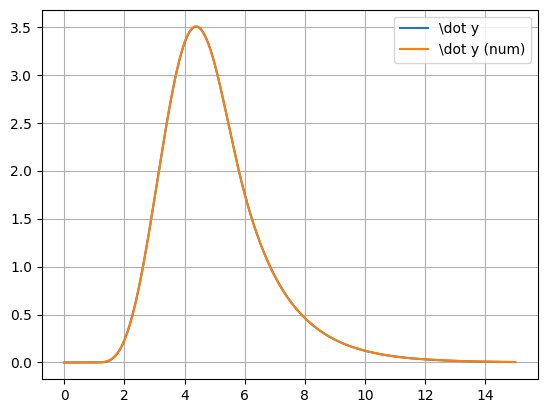

In [18]:
plt.plot(t_vals, yDot_vals, label="\\dot y")
plt.plot(t_vals, yDot_num_vals, label="\\dot y (num)")
plt.legend()
plt.grid()

### von $\ddot y$

In [19]:
plt.plot(t_vals, yDDot_vals, label="\\dot y")
plt.plot(t_vals, yDDot_num_vals, label="\\dot y (num)")
plt.legend()
plt.grid()

### von $y^{(3)}$

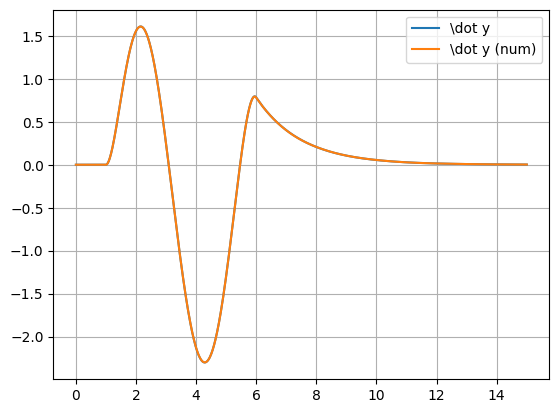

In [20]:
plt.plot(t_vals, yDDDot_vals, label="\\dot y")
plt.plot(t_vals, yDDDot_num_vals, label="\\dot y (num)")
plt.legend()
plt.grid()

### von $u$

In [21]:
def control(y, ydot, yddot, ydddot):
    return ydddot + ((T1*T2 + T1*T3 + T2*T3)/(T1*T2*T3))*yddot + ((T1 + T2 + T3)/(T1*T2*T3))*ydot + (1/(T1*T2*T3))*y


u_vals = control(y_vals, yDot_vals, yDDot_vals, yDDDot_vals)

In [22]:
plt.plot(t_vals, u_vals, color="tab:orange")
plt.xlabel("$t$ (s)")
plt.ylabel("$u$")
plt.title("Verlauf der Stellgröße")
plt.grid()
# plt.savefig("siso_u.pdf", dpi=300)

## Überprüfung der Steuertrajektorie

Mit der berechneten Steuertrajektorie wird das System jetzt simuliert, um zu prüfen, ob der tatsächliche Verlauf für $\eta$ herauskommt.

Zunächst wird die rechte Seite des Dgl.-Systems recht schlampig implementiert:

In [23]:
def system(t, x):
    y, ydot, yddot, ydddot = y_traj(t)
    u = control(y, ydot, yddot, ydddot)
    return [x[1],
            x[2],
            u - (1.0/(T1*T2*T3))*(x[0] + (T1+T2+T3)*x[1] + (T1*T2 + T1*T3 + T2*T3)*x[2])]

Jetzt wird das System simuliert:

In [24]:
sol = sci.solve_ivp(system, [t_vals[0], t_vals[-1]], [y0, 0, 0], t_eval=t_vals)
eta = (1.0/(T1*T2*T3))*(K*sol.y[0,:] + K*Tn*sol.y[1,:])

Darstellung der Ergebnisse

In [25]:
plt.plot(t_vals, eta_vals, label="$\\eta_{ref}$")
plt.plot(t_vals, eta, label="$\\eta$")
plt.legend()
plt.xlabel("t (s)")
plt.ylabel("$\\eta$ (V)")
plt.title("Verlauf des Ausgangs $\\eta$ bei Steuerung durch u")
plt.grid()

In [26]:
plt.plot(t_vals, eta - eta_vals)
plt.title("Absoluter Fehler")
plt.xlabel("t (s)")
plt.grid()

**Es scheint also alles wie gewünscht zu funktionieren!**